# FML final assignment: who is it?


## Introduction
   
Through wearing a Fitbit watch, users are constantly being tracked and that means a lot of data is available. Both my mother and my sister have been wearing a fitbit watch for more than 3 years. That is a lot of data to be collected and analysed. I was curious if I can spot data patterns and apply a machine learning algorithm in order to predict who out of the two a specific data point would belong to. So the following research question was formed: "Based on their fitbit data, can an algorithm predict if it is my mother Petra or my sister Julia?"    
    

#### Imports go where imports go

In [1]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## About the dataset

So, the first task was getting the data. After both family members consented to their data being analysed, I was able to request the data through their Fitbit accounts. Within a day I received a zip folder with json files about monthly step and sleep data from the last years. Ideally all data needed to be combined into one csv file to be used for the analysis. Achieving this took multiple steps. Out of personal preference that was all done using Visual Studio Code.

The first challenge presented itself in writing a loop to loop through every json file and retract relevant data on the steps per date. (see appendix)

The output of the first loop was a df with all steps from Julia. The column df['Name']='Julia' was added to the dataframe so that it could be specified who this data belongs to. The process was repeated to get the step data from my mother. 

Next, the process was repeated to receive the sleep data from each person. The column of dateTime was called different in the sleep file so it was renamed using 

            df_sleep.rename(columns = {"dateOfSleep": "dateTime"}, inplace = True)
            
The result was a step dataframe containing (dateTime, value, Name) for each person and a dataframe containing (dateTime, minutesAsleep, Name) for each person. I saved these in the form of csv files.  

One of the biggest challenges was merging the datasets to become one dataframe to be used for further analysis.

In the end, I first created a dataframe per person through merging the step and sleep data from either person and then concatenating these using: 

        df_mom = pd.read_csv("all_petra.csv")
        df_sis= pd.read_csv("all_julia.csv")

        df=pd.concat([df_mom, df_sis])

After that was achieved, only minimal data cleaning needed to take place. 

## The dataframe

In [2]:
df = pd.read_csv('FML.csv')
df=df.drop(["Unnamed: 0", "Name_y"], axis = 1)
df['dateTime'] = pd.to_datetime(df['dateTime'])
df = df.dropna()
print(df.head())

    dateTime Name_x  value  minutesAsleep
1 2016-12-26  Petra   6580           59.0
2 2016-12-26  Petra   6580          554.0
3 2016-12-27  Petra  11171          126.0
4 2016-12-27  Petra  11171          429.0
5 2016-12-28  Petra  11489          515.0


The uploaded dataframe in the end consisted of the date, the name of the person, the value which means number of steps per day and the minutes asleep. 

### Cleaning outliers

There were a couple of high and low outliers in the steps. Daily steps values below 500 steps were excluded. Likewise there was an outlier of 40000 steps, while this is a stepcount that actually happened, it was excluded in order to achieve the best possible analysis. The maximum line of steps was set at 32000 steps because there are a couple more values there, which can be described as high peaks. 

The sleep values posed somewhat as a question mark. There are some sleep values below 100 minutes, which were first thought to be an error. After closer examination it became clear that these low sleep values are naps. While a function was written to remove the naps from the dataframe, the discovery was made that the model works a bit better if they are included. Hence, the decision was made to keep the naps and only remove one sleep outlier with the value of below 20min.  

In [3]:
#df = df.dropna()
#(df.head())

def fix_low_outliers(x):
    if(x < 500): 
        return float('NaN')
    else: 
        return x
    
    
def fix_high_outliers(x):
    if(x > 32000): 
        return float('NaN')
    else: 
        return x

df['value'] = df['value'].apply(fix_low_outliers)
df['value'] = df['value'].apply(fix_high_outliers)


def fix_sleep_outliers(x):
    if(x < 20): 
        return float('NaN')
    else: 
        return x

df['minutesAsleep'] = df['minutesAsleep'].apply(fix_sleep_outliers) 

## Feature engineering

There were some feature engineering steps implemented for a better, more thorough analysis of the data. First the column ["day"] was added to specify the day of the week. The value 0 means monday, 6 means sunday, and all other numbers everything in between. Additionally, the seasons were added with the help of a function to investigate whether the seasons impact the data. 
The feature engineering further allowed for a better, more accurate prediction of the algorithm. 


In [4]:
df["day"] = df["dateTime"].dt.dayofweek
print(df)

       dateTime Name_x    value  minutesAsleep  day
1    2016-12-26  Petra   6580.0           59.0    0
2    2016-12-26  Petra   6580.0          554.0    0
3    2016-12-27  Petra  11171.0          126.0    1
4    2016-12-27  Petra  11171.0          429.0    1
5    2016-12-28  Petra  11489.0          515.0    2
...         ...    ...      ...            ...  ...
2679 2020-12-12  Julia   6562.0          545.0    5
2680 2020-12-13  Julia   6375.0          291.0    6
2681 2020-12-14  Julia   6144.0          441.0    0
2682 2020-12-15  Julia  11281.0          368.0    1
2684 2020-12-17  Julia   2271.0          495.0    3

[2192 rows x 5 columns]


In [5]:
#function to add season 

def season(x):
    month = x.month
    
    if (month ==12 or month <= 2):
        return "winter"
    elif (month >= 3 and month <=5):
        return "spring"
    elif (month >= 6 and month <=8):
        return "summer"
    elif (month >= 9 and month <= 11):
        return "autumn"
    
df["seasons"] = df["dateTime"].apply(season)

dummies = pd.get_dummies(df["seasons"]) #in order to use the seasons dummies need to be created

dummies

,autumn,spring,summer,winter
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
5,0,0,0,1
...,...,...,...,...
2679,0,0,0,1
2680,0,0,0,1
2681,0,0,0,1
2682,0,0,0,1


In order for the seasons and weekdays to be used later by the algorithm, dummy variables needed to be created. 

In [6]:
df = pd.concat([df, dummies], axis=1) #adding season dummies to the df

In [7]:
dummies = pd.get_dummies(df['day']) #getting day dummies

The dummy variables were added to the dataframe and renamed to the respective days. The final dataframe looks the following: 

In [8]:
df = pd.concat([df, dummies], axis=1) #adding day dummies to the df
df=df.rename(columns = {0: "monday", 1: "tuesday", 2: "wednesday", 3:"thursday", 4:"friday", 5:"saturday", 6:"sunday"}, inplace = False)

## The final dataframe

In [9]:
df.head(5)

,dateTime,Name_x,value,minutesAsleep,day,seasons,autumn,spring,summer,winter,monday,tuesday,wednesday,thursday,friday,saturday,sunday
1,2016-12-26,Petra,6580.0,59.0,0,winter,0,0,0,1,1,0,0,0,0,0,0
2,2016-12-26,Petra,6580.0,554.0,0,winter,0,0,0,1,1,0,0,0,0,0,0
3,2016-12-27,Petra,11171.0,126.0,1,winter,0,0,0,1,0,1,0,0,0,0,0
4,2016-12-27,Petra,11171.0,429.0,1,winter,0,0,0,1,0,1,0,0,0,0,0
5,2016-12-28,Petra,11489.0,515.0,2,winter,0,0,0,1,0,0,1,0,0,0,0


## Descriptive analysis 
  
Now that the final dataframe was created, the analysis of the data could begin. The decision was made to exclude a pairplot from the analysis as it was very big and did not provide many insights. Instead this analysis starts with a distplot about the total stepcount. 

### Steps

The median number of steps is: 9443.0
The mean number of steps is: 10064.124137931034
The mode of steps is: 7925.0


C:\Users\CeBo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


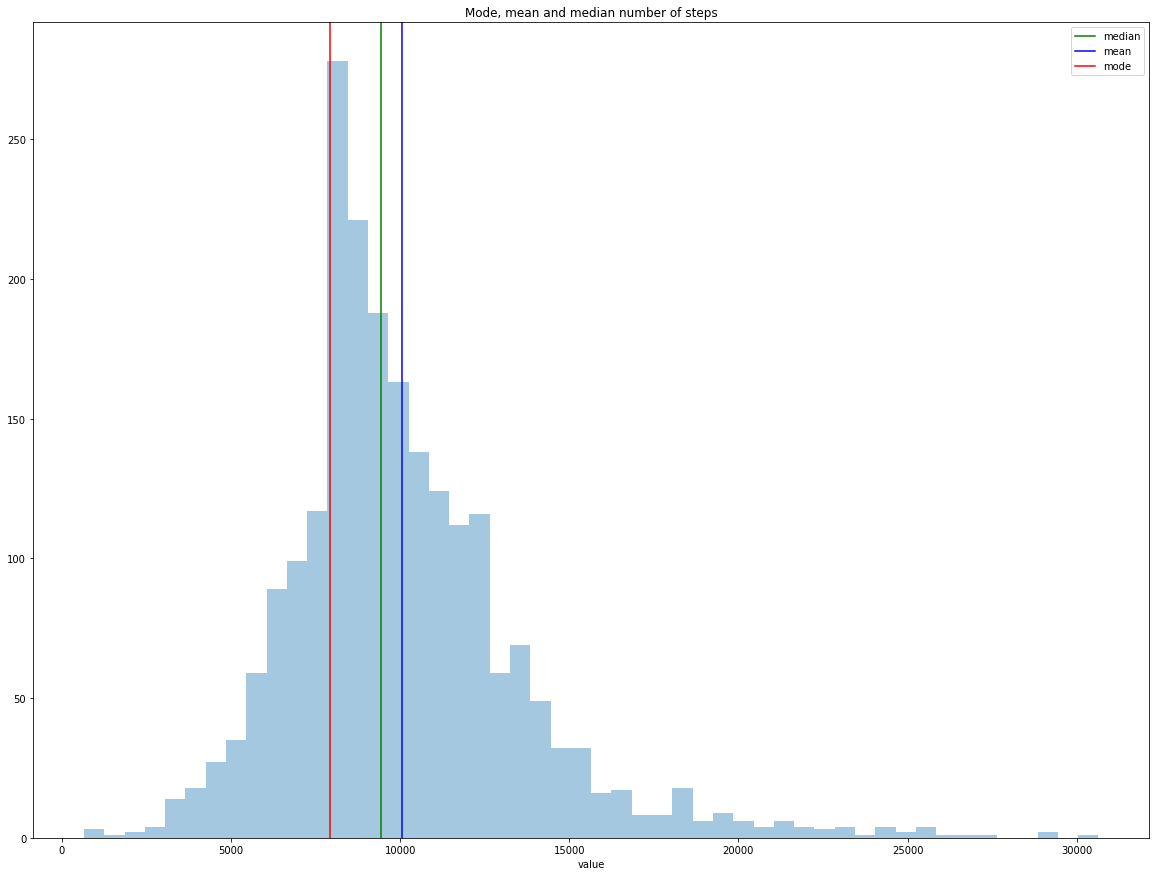

In [10]:
mean_size = df['value'].mean()
median_size = df['value'].median()
mode = df['value'].mode().tolist()[0]

print(f'The median number of steps is: {median_size}')
print(f'The mean number of steps is: {mean_size}')
print(f'The mode of steps is: {mode}')

steps = df['value'].dropna()

plt.subplots(figsize=(20,15))
sns.distplot(steps, kde=False)
plt.title('Mode, mean and median number of steps')
plt.axvline(median_size, 0, 100, color='green', label='median') #This adds a vertical line at x-position median_size
plt.axvline(mean_size, 0, 100, color='blue', label='mean') 
plt.axvline(mode, 0, 100, color='red', label='mode')
plt.legend() #This adds a legend. It works automatically because I've set the labels in the previous lines
plt.show()

#### Mean, median and mode number of steps per day without distinction between person

The first graph represents the number of steps and their frequency without making a distinction per person. We can see that the mean number of steps lies at 10063 and the median a bit lower with 9442 steps. The mode, meaning the value with the highest frequency lies at 7925 number of steps per day. Now let's look more closely in the differences in number of steps per person. 

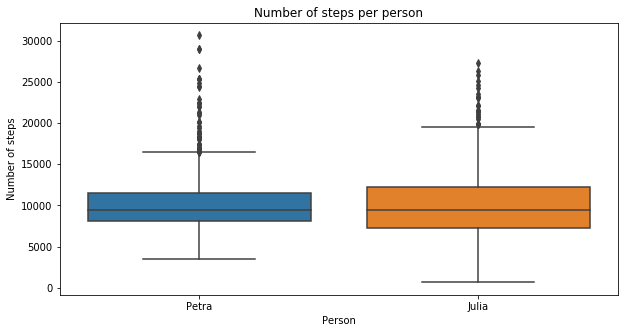

In [11]:
plt.subplots(figsize=(10,5))
sns.boxplot(y=df["value"], x=df["Name_x"])
plt.title('Number of steps per person')
plt.xlabel('Person')
plt.ylabel('Number of steps')

plt.show()

A boxplot is a nice means of visualization of the median and distribution of steps per person. Here we can see that the median value of number of steps per day is about the same with around 10000 steps. It furthermore can be observed that the interquartile range of the orange boxplot is larger, meaning that there is higher variance in the steps of Julia. Both boxplots furthermore have high outliers that reach beyond the whiskers of the boxplot.

Let's take a closer look at the timeline.

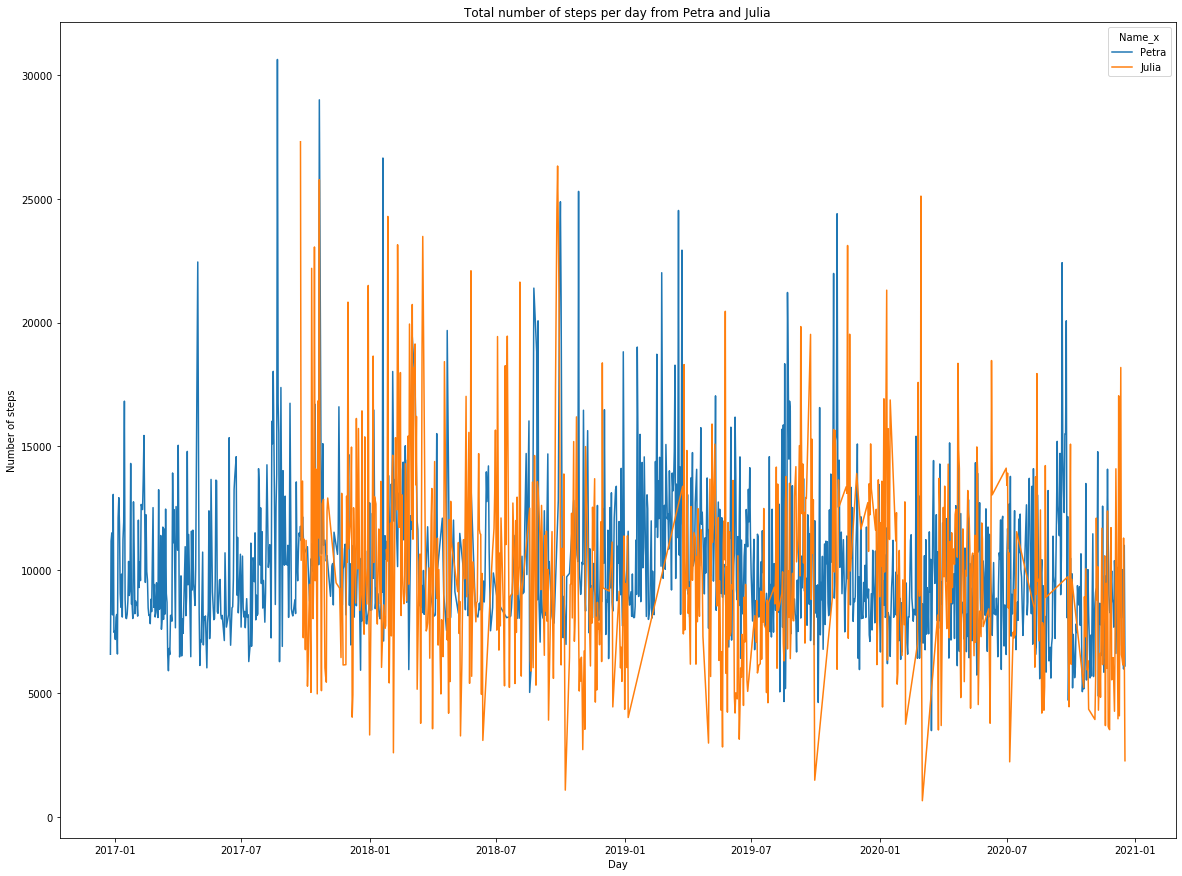

In [12]:
plt.subplots(figsize=(20,15))
sns.lineplot(x="dateTime", y="value", data=df, hue="Name_x")
plt.title('Total number of steps per day from Petra and Julia')
plt.xlabel("Day")
plt.ylabel("Number of steps")
plt.show()

#### Timeline of the number of steps per person
In the lineplot above the number of steps per person throughout the years is visualized. There are various things that can be said about this graph. First of all, my mother (in blue) started using the fitbit watch a bit earlier, as of december 25 2016. My sister started wearing the fitbit 9months later. Additionally, her fitbit watch broke in the beginning of 2019, which explains the missing data until she got a new watch.  

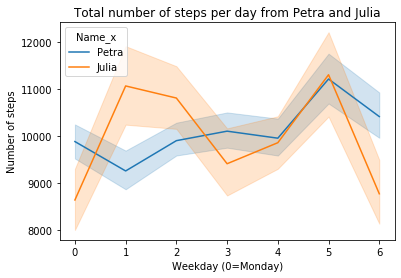

In [13]:
sns.lineplot(x="day", y="value", data=df, hue="Name_x")
plt.title('Total number of steps per day from Petra and Julia')
plt.xlabel("Weekday (0=Monday)")
plt.ylabel("Number of steps")
plt.show()

The data can be inspected even more closely by looking at the different days of the week. Saturday both Petra and Julia have the highest average number of steps. It is interesting to see the statistics, because I can interpret them due to my knowledge of the people whose data this is. I can for example see that tuesday is a day where Julia has many steps. I know that is because she has handball practise on that day and therefore will lead to a higher number of steps. 

### Sleep

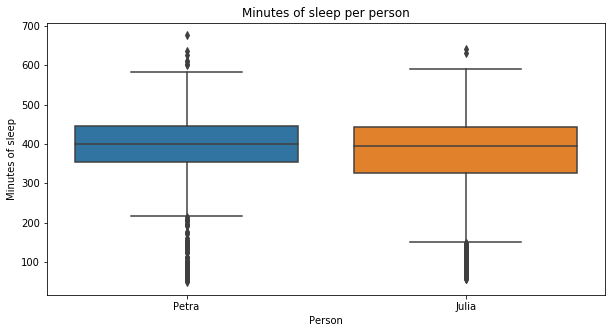

In [14]:
plt.subplots(figsize=(10,5))
sns.boxplot(y=df["minutesAsleep"], x=df["Name_x"])
plt.title('Minutes of sleep per person')
plt.xlabel('Person')
plt.ylabel('Minutes of sleep')

plt.show()

Let's start examining the sleep per person again with the help of a boxplot. The first thing to be pointed out is that the median is very similar again with both getting around 400 minutes of sleep on average. While the blue boxplot seems to be symmetric, the first quartile of the orange boxplot is larger than the third quartile. This indicates that these data points are more spread out than those in Q3. Several outliers can be observed on the high as well as the low end of minutes of sleep. As pointed out earlier, the low outliers are naps and high outliers simply represent a very good nights sleep.

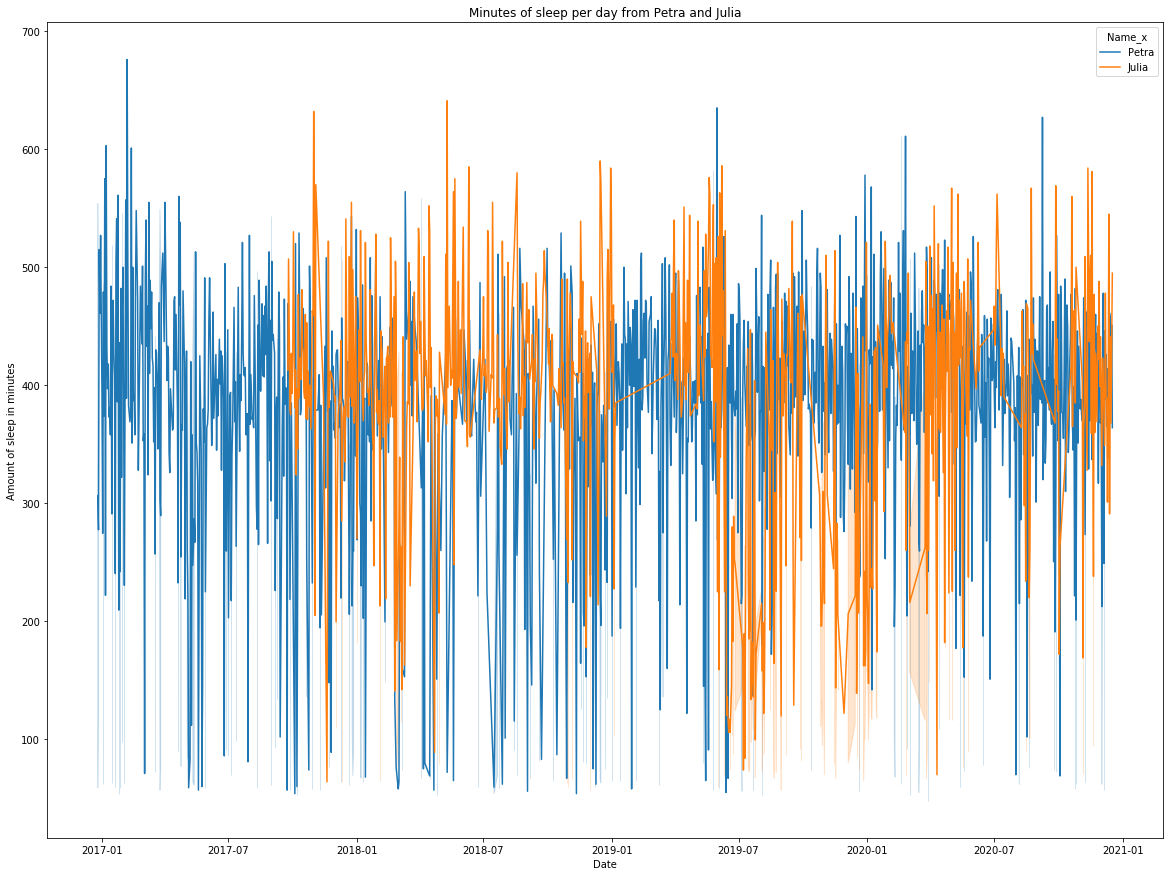

In [15]:
plt.subplots(figsize=(20,15))
sns.lineplot(x="dateTime", y="minutesAsleep", data=df, hue="Name_x")
plt.title('Minutes of sleep per day from Petra and Julia')
plt.xlabel("Date")
plt.ylabel("Amount of sleep in minutes")
plt.show()

When visualizing this data in a lineplot the outliers become more visible. As mentioned in the data cleaning section, the decision was made to keep the outliers as they positively impact the algorithm. Let's see if perhaps seasons impact the sleep?

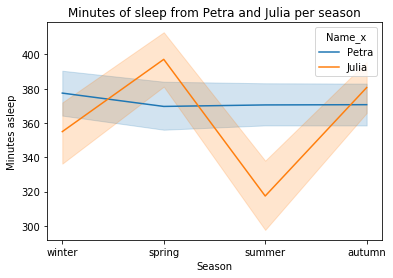

In [16]:
sns.lineplot(x="seasons", y="minutesAsleep", data=df, hue="Name_x")
plt.title('Minutes of sleep from Petra and Julia per season')
plt.xlabel("Season")
plt.ylabel("Minutes asleep")
plt.show()

This graph represents the average sleeping pattern per person per season. What can be seen immediately is that my mother has a lot more stable sleep pattern than my sister. While Petra gets an average amount of sleep around 6h throughout all seasons, the sleep of Julia is a lot more irregular. With the background knowledge that she is a young mother who gave birth to her first baby in summer, it makes sense that her amount of sleep in summer is the lowest. 

## Building the Predictive Model

In order to build a predicted model to answer the research question, a supervised learning approach was chosen. More specifically, due to the nature of the y variable a classification algorithm needed to be employed. 

### K-nn
The first algorithm that was tested out was the more simple k-nearest neighbor algorithm. This algorithm looks at the closest data records in reference data and determines the class based on the distance to the majority of the neighbors (Srivastava, 2018). In this case, if most neighbors belong to the category "Petra", the data point will be assigned to this class. Next to determining the y and X variables, an essential step of supervised learning is splitting the data into a training and a test set. 
Now I want to know how much of the data the algorithm predicts correctly. This is called *accuracy*.
Regardless of the X variables chosen for analysis, **the best result to be achieved which the knn algorithm was an accuracy of 65%**, setting k to include 7 neighbors. 

In [17]:
df=df.dropna()
X = df[['value', 'minutesAsleep', 'summer', 'tuesday']] #including more or less X variables didnt change the outcome
y = df["Name_x"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train.head() #show the head of the training set

,value,minutesAsleep,summer,tuesday
2624,7282.0,365.0,0,0
575,11501.0,467.0,0,0
2483,10507.0,178.0,0,1
1687,8521.0,390.0,0,0
1654,9249.0,64.0,0,0


In [18]:
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors=7) #a KNN-classifier with 7 neighbors had the best result
knn = knn.fit(X_train, y_train) #this fits the k-nearest neighbor model with the train data
knn.score(X_test, y_test) 

0.6508422664624809

### Random forest

Another classification algorithm that can be employed to make class predictions is random forest. Random forest is an extension of the decision tree, in that the random forest employs many decision trees to arrive at the best possible outcome in terms of classification. The advantage over a simple decision tree is that instead of using one tree, many random trees have more potential to provide a correct prediction. There the number of votes for the class from each tree determine the prediction (Yiu, 2019). 


The **first attempt** to create a **random forest** prediction model resulted in a result slightly worse than the one from the knn model with an accuracy of **64%**. 


In [19]:
X = df[['value', 'minutesAsleep', 'summer', 'tuesday']] # first attempt
y = df["Name_x"]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=1)

X_train1.head() #show the head of the training set

,value,minutesAsleep,summer,tuesday
2624,7282.0,365.0,0,0
575,11501.0,467.0,0,0
2483,10507.0,178.0,0,1
1687,8521.0,390.0,0,0
1654,9249.0,64.0,0,0


In [20]:
#random forest
rf = RandomForestClassifier(random_state=1, n_estimators=100) #RF is a random algorithm, so to get the same results we need to use random_state
rf = rf.fit(X_train1, y_train1)
rf.score(X_test1, y_test1) #accuracy

0.6477794793261868

But surely there was something that could be done to improve this result?
And yes there was. By including all dummy variables of season and days, the algorithm could be improved to an **accuracy of 72%!**

In [21]:
#x variables of second attempt
X = df[['value', 'minutesAsleep', 'spring','summer','winter', 'autumn', 'monday', 'tuesday', 'wednesday', 'thursday','friday','saturday', 'sunday']] 
y = df["Name_x"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=1)

X_train2.head() #show the head of the training set

,value,minutesAsleep,spring,summer,winter,autumn,monday,tuesday,wednesday,thursday,friday,saturday,sunday
2624,7282.0,365.0,0,0,0,1,0,0,1,0,0,0,0
575,11501.0,467.0,1,0,0,0,1,0,0,0,0,0,0
2483,10507.0,178.0,1,0,0,0,0,1,0,0,0,0,0
1687,8521.0,390.0,0,0,1,0,0,0,0,0,1,0,0
1654,9249.0,64.0,0,0,0,1,0,0,0,0,0,0,1


In [22]:
#random forest
rf = RandomForestClassifier(random_state=1, n_estimators=100) #RF is a random algorithm, so to get the same results we need to use random_state
rf = rf.fit(X_train2, y_train2)
rf.score(X_test2, y_test2) #accuracy

0.7274119448698315

In [23]:
y_pred = rf.predict(X_test2) #the predicted values
cm = confusion_matrix(y_test2, y_pred) #creates a "confusion matrix"
cm = pd.DataFrame(cm, index=['Julia (actual)', 'Petra (actual)'], columns = ['Julia (pred)', 'Petra (pred)']) #label and make df
cm

,Julia (pred),Petra (pred)
Julia (actual),126,99
Petra (actual),79,349


The confusion matrix shows that after including all variables, a total of 349 cases were correctly predicted as belonging to my mother. Likewise, 126 cases were correctly identified as belonging to my sister. 99 cases who were predicted as my mother actually belonged to my sister and 79 cases the other way around. 

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Julia       0.61      0.56      0.59       225
       Petra       0.78      0.82      0.80       428

    accuracy                           0.73       653
   macro avg       0.70      0.69      0.69       653
weighted avg       0.72      0.73      0.72       653



The accuracy of the algorithm can be investigated more closely by looking at the precision and recall. First of all, let's look at what these terms mean. Precision is determined by dividing the "true positives" by the sum of the predicted positives (Huilgol, 2020). Meaning out of all cases that belonged to that category, how many were correctly identified. Recall on the other hand, takes the number of true positives divided by true positives and false negatives (number of actual positives)(Koehrsen, 2019). 

If we for example wanted to calculate the precision and recall for the category "Julia" it looks like this:

$precision = \frac{126}{126 + 79} = 0.61$
 
$recall = \frac{126}{126 + 99} = 0.56$

The classification report does these calculations for us, but now we know what these values mean and that they are correct. When we take a look at the precision and recall for Julia and Petra we can see that the algorithm can more accurately predict the cases that belong to Petra. 39% of cases that would belong to the category Julia were predicted wrong, while that is true for only 22% of cases for Petra. 78% of times a case that was labeled as Petra, was correctly identified as Petra. Recall of the category "Julia" performs worst with 56%, meaning that 56% of cases that were actually Julia were labeled as such. 

Both precision as well as recall are significantly higher for Petra than for Julia. This can be due to the reason that there is more data from Petra and that, as we have seen in the descriptive analysis, the data is a lot more stable than the one from the young mother Julia.


## Evaluation & Conclusion

All in all, the model performed reasonably well. As this is no project about breast cancer or fraud, the model does not need to be somewhere around 90% accurate. At the same time, the model performed better than a random guess. Furthermore, with 72% accuracy the original result was visibly improved. 

While there is little practical value of this research beyond this project, it did help me in learning more about predictive models and how they can be applied. The research brought all steps from data gathering, data cleaning, descriptive analysis and building a predictive model together as a unified project. This same approach can be applied to cases with higher practical relevance. Perhaps a similar model can be applied in the context of health insurance. There is a lot of discussion around using data such as fitbit data in connection with health insurance (Boyd, 2017). In case that becomes true, some people will probably try to trick the system using other people's data to get a better insurance deal. An algorithm like this could predict if the data actually belongs to the person or someone else. 



### Appendix

#### The loop used to gather the data 

In [25]:
#import json 
#import pandas as pd 

#def open_json(filename):
#    with open(filename) as json_file:
#        data = json.load(json_file)
#    return data


#def write_json(data, filename):
#    with open(filename, "w") as outfile:
#        json.dump(data, outfile, indent=4, sort_keys=True)


#df = pd.read_json("sleep-2017-09.json")


#for year in range(2017,2021):
#    for month in range(1,13):
#        if year == 2017 and month < 10:
#            continue 

#        elif year == 2019 and month < 3:
#            continue
    
#        elif month < 10:
#            filename = "sleep-"+str(year)+"-0"+str(month)+".json"
#            temp_df = pd.read_json(filename)
#            df=pd.concat([df, temp_df], axis =0)

#        else:
#            filename = "sleep-"+str(year)+"-"+str(month)+".json"
#            temp_df = pd.read_json(filename)
#            df=pd.concat([df, temp_df], axis =0)
    
#df['Name']='Julia'


#df_sleep = df[["dateOfSleep","minutesAsleep","Name"]]

#df_sleep.to_csv("all_sleep_julia.csv")


##### References

Boyd, A. (2017, February 17). Could your Fitbit data be used to deny you health insurance? The Conversation. https://theconversation.com/could-your-fitbit-data-be-used-to-deny-you-health-insurance-72565

Huilgol, P. (2020, December 29). Precision vs. Recall – An Intuitive Guide for Every Machine Learning Person. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/09/precision-recall-machine-learning/

Koehrsen, W. (2018, July 9). Beyond Accuracy: Precision and Recall - Towards Data Science. Medium. https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

Srivastava, T. (2018, March 27). Introduction to k-Nearest Neighbors: A powerful Machine Learning Algorithm (with implementation in Python & R). Analytics Vidhya. https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/

Yiu, T. (2019, August 14). Understanding Random Forest - Towards Data Science. Medium. https://towardsdatascience.com/understanding-random-forest-58381e0602d2





### *Notebook by: Celina Breitenborn*